# Testing CNNs

needs python 3.10 to run, tensorflow is not compatible with 3.12

In [13]:
import sys
import sklearn
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image

%matplotlib inline
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


np.random.seed(42)
tf.random.set_seed(42)

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


In [10]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

def crop(images):
    return images[150:220, 130:250]

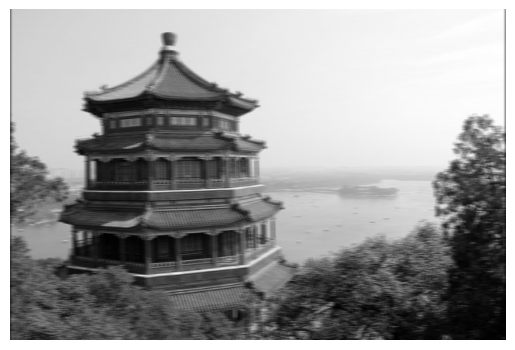

In [8]:
flower = load_sample_image("flower.jpg") / 255
china = load_sample_image("china.jpg") / 255
imgs = np.array([china, flower])
batch_size, height, width, channels = imgs.shape

filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1   #vertical line
filters[3, :, :, 1] = 1  #horizontal line

outputs = tf.nn.conv2d(imgs, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

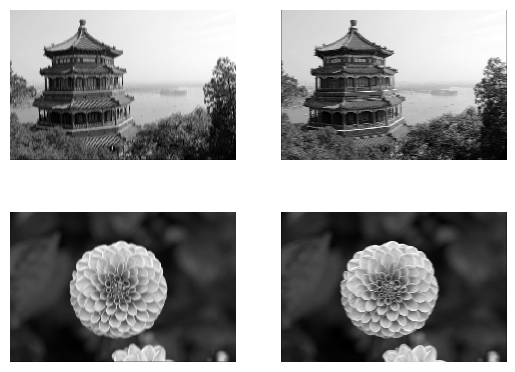

In [9]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

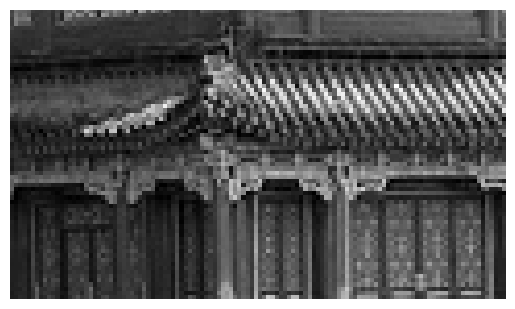

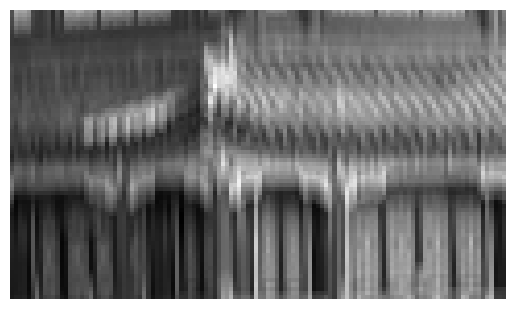

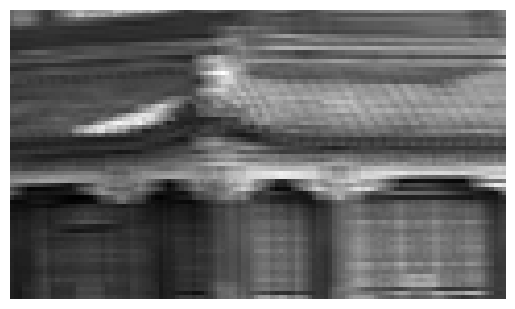

In [11]:
plot_image(crop(imgs[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

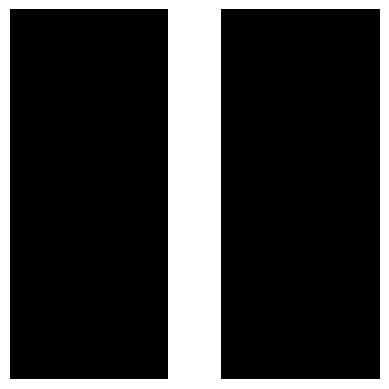

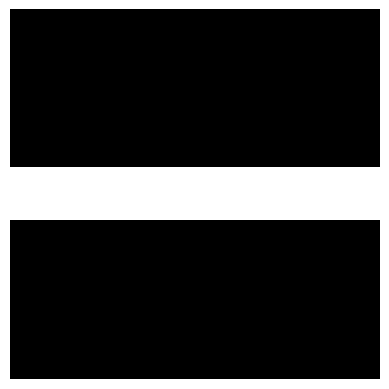

In [12]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## Custom CNN

### Convolutional Layer

In [16]:
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

conv_outputs = conv(imgs)
conv.set_weights([filters, np.zeros(2)])

conv_outputs.shape 

TensorShape([2, 427, 640, 2])

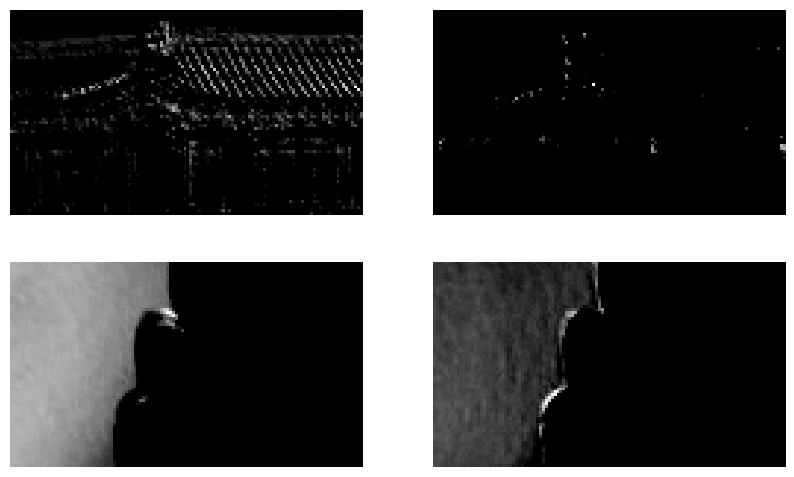

In [15]:
plt.figure(figsize=(10,6))

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
        
plt.show()

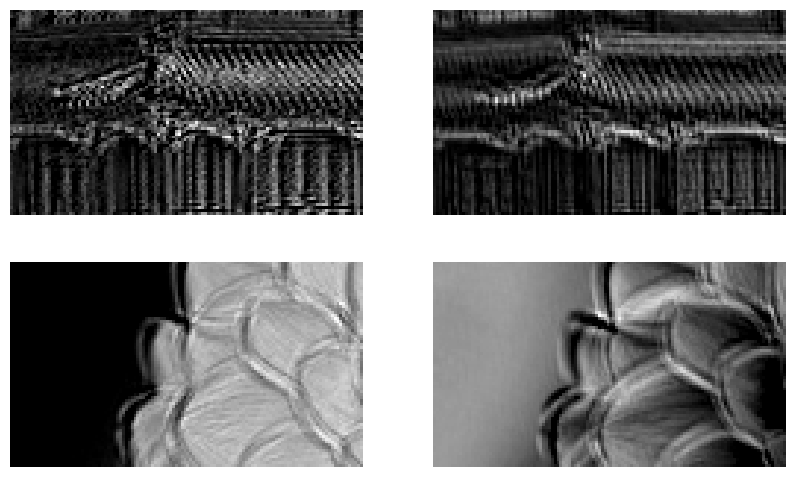

In [17]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

#### Padding 

VALID vs SAME

In [19]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1   
    


def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2  

    return pad_before, padded_size


def manual_same_padding(imgs, kernel_size, strides=1):
    if kernel_size == 1:
        return imgs.astype(np.float32)
    
    batch_size, height, width, channels = imgs.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = imgs   

    return padded_images



kernel_size = 7
strides = 2


conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(imgs, kernel_size, strides))

conv_same.build(tf.TensorShape(imgs.shape))
conv_same.set_weights(conv_valid.get_weights())
same_output = conv_same(imgs.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())